In [1]:
import numpy as np
import pandas as pd
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

from bart_playground import Tree, Parameters
from bart_playground import Break, Combine, Grow, Birth, Death
from bart_playground import Dataset
from bart_playground import visualize_tree 
from bart_playground import *  # Import the updated DataGenerator class

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rng = np.random.default_rng(42)

In [3]:
def tearDown(filename):
    expected_filepath = f"{filename}.png"
    if os.path.exists(expected_filepath):
        os.remove(expected_filepath)

In [4]:
prior = ComprehensivePrior(n_trees=1, tree_alpha=0.95, tree_beta=2.0, f_k=2.0, eps_q=0.9, 
                            eps_nu=3, specification="linear", generator=rng, theta_0=1, theta_df=np.inf, tau_k=2.0,
                            tree_num_prior_type="bernoulli")

In [5]:
tree1 = Tree.new(dataX=X_train)
trees = [tree1]
params = Parameters(trees, {"eps_sigma2": 0.005})
new_leaf_vals = prior.tree_prior.resample_leaf_vals(params, data_y = y_train, tree_ids = [0])
params.update_leaf_vals([0], new_leaf_vals)
params.trees

[Tree(vars=[-1 -2 -2 -2 -2 -2 -2 -2], thresholds=[nan nan nan nan nan nan nan nan], leaf_vals=[0.32305818        nan        nan        nan        nan        nan
         nan        nan], n_vals=[120  -2  -2  -2  -2  -2  -2  -2])]

In [6]:
preprocessor = DefaultPreprocessor()
possible_thresholds=preprocessor.gen_thresholds(X=X)

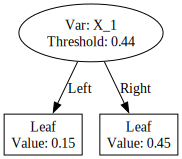

In [7]:
move = Grow(params, trees_changed=[0], possible_thresholds=possible_thresholds)
move.propose(rng)
leaf_vals_samples = []
for _ in range(1000):
    new_leaf_vals = prior.tree_prior.resample_leaf_vals(move.proposed, data_y=y_train, tree_ids=[0])
    leaf_vals_samples.append(new_leaf_vals)
mean_leaf_vals = np.mean(leaf_vals_samples, axis=0)
move.proposed.update_leaf_vals([0], mean_leaf_vals)
trees = move.proposed.trees
tree_g = move.proposed.trees[0]
filename_g = "tree_g"
visualize_tree(tree_g, filename=filename_g, format="png")

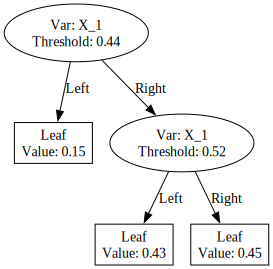

In [8]:
params = Parameters(trees, {"eps_sigma2": 0.005})
move = Grow(params, trees_changed=[0], possible_thresholds=possible_thresholds)
move.propose(rng)
leaf_vals_samples = []
for _ in range(1000):
    new_leaf_vals = prior.tree_prior.resample_leaf_vals(move.proposed, data_y=y_train, tree_ids=[0])
    leaf_vals_samples.append(new_leaf_vals)
mean_leaf_vals = np.mean(leaf_vals_samples, axis=0)
move.proposed.update_leaf_vals([0], mean_leaf_vals)
tree_gg = move.proposed.trees[0]
filename_gg = "tree_gg"
visualize_tree(tree_gg, filename=filename_gg, format="png")

In [9]:
trees = [tree_gg]
params = Parameters(trees, {"eps_sigma2": 0.005})
params.trees

[Tree(vars=[ 1 -1  1 -2 -2 -1 -1 -2], thresholds=[0.43751698        nan 0.52339864        nan        nan        nan
         nan        nan], leaf_vals=[       nan 0.14604766        nan        nan        nan 0.43124902
  0.45360376        nan], n_vals=[120  51  69  -2  -2  12  57  -2])]

# Break

In [10]:
move = Break(params, trees_changed=[0])
move.propose(rng)
leaf_vals_samples = []
for _ in range(1000):
    new_leaf_vals = prior.tree_prior.resample_leaf_vals(move.proposed, data_y=y_train, tree_ids=[0,-1])
    leaf_vals_samples.append(new_leaf_vals)
mean_leaf_vals = np.mean(leaf_vals_samples, axis=0)
move.proposed.update_leaf_vals([0,-1], mean_leaf_vals)
move.proposed.trees

[Tree(vars=[ 1 -1 -1 -2], thresholds=[0.43751698        nan        nan        nan], leaf_vals=[       nan 0.00764592 0.29730042        nan], n_vals=[120  51  69  -2]),
 Tree(vars=[ 1 -1 -1 -2], thresholds=[0.52339864        nan        nan        nan], leaf_vals=[       nan 0.14446823 0.15540548        nan], n_vals=[120  63  57  -2])]

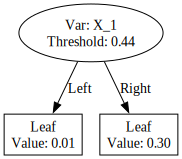

In [11]:
tree_b1 = move.proposed.trees[0]
filename1 = "tree_b1"
visualize_tree(tree_b1, filename=filename1, format="png")

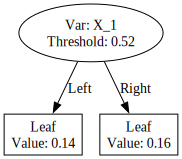

In [12]:
tree_b2 = move.proposed.trees[-1]
filename2 = "tree_b2"
visualize_tree(tree_b2, filename=filename2, format="png")

In [13]:
final = move.proposed
preds = np.zeros((X_test.shape[0], 1))
for k in range(1):
    y_eval = final.evaluate(X_test)
    preds[:, k] = y_eval
y_pred = np.mean(preds, axis=1)

In [14]:
y_test

array([ 0.57494339, -0.39107825,  0.03833771, -0.10585361,  0.58205285,
       -0.46879905, -0.12964723,  0.48524713,  0.30069396,  0.48688625,
        0.49330468,  0.4528224 ,  0.5750869 ,  0.55541165,  0.43010696,
        0.6155312 ,  0.44660998,  0.51601906,  0.48824578,  0.18206462,
        0.37483528, -0.15720403,  0.57823503,  0.43025762,  0.56087615,
        0.49741372, -0.02658388,  0.4874991 ,  0.04278904, -0.06782644,
       -0.03427862,  0.54396366,  0.52023062, -0.14805365,  0.61774119,
        0.54746971,  0.58137637, -0.46316434,  0.29964777,  0.55300647])

In [15]:
y_pred

array([0.29730042, 0.00764592, 0.00764592, 0.00764592, 0.00764592,
       0.00764592, 0.00764592, 0.29730042, 0.29730042, 0.00764592,
       0.29730042, 0.29730042, 0.29730042, 0.00764592, 0.00764592,
       0.29730042, 0.00764592, 0.29730042, 0.29730042, 0.00764592,
       0.29730042, 0.29730042, 0.00764592, 0.29730042, 0.29730042,
       0.29730042, 0.00764592, 0.29730042, 0.00764592, 0.29730042,
       0.29730042, 0.29730042, 0.29730042, 0.00764592, 0.29730042,
       0.00764592, 0.29730042, 0.00764592, 0.00764592, 0.29730042])

In [16]:
mean_squared_error(y_test, y_pred)

0.10116863791449501

-----------------------------------------------Stop here----------------------------------------------------------

# Combine

In [17]:
rng = np.random.default_rng(24)
trees = [tree1]
params = Parameters(trees, {"eps_sigma2": 1})
move = Grow(params, trees_changed=[0], possible_thresholds=possible_thresholds)
move.propose(rng)
tree_g_2 = move.proposed.trees[0]

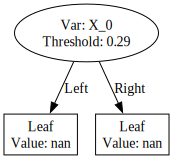

In [18]:
filename_g2 = "tree_g_2"
visualize_tree(tree_g_2, filename=filename_g2, format="png")

In [19]:
trees = [tree_g,tree_g_2]
params = Parameters(trees, {"eps_sigma2": 1})
params.trees

[Tree(vars=[ 1 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.43751698        nan        nan        nan        nan        nan
         nan        nan], leaf_vals=[       nan 0.14503477 0.45004702        nan        nan        nan
         nan        nan], n_vals=[120  51  69  -2  -2  -2  -2  -2]),
 Tree(vars=[ 0 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.28854788        nan        nan        nan        nan        nan
         nan        nan], leaf_vals=[nan nan nan nan nan nan nan nan], n_vals=[120  39  81  -2  -2  -2  -2  -2])]

In [20]:
move = Combine(params, trees_changed=[0,1])
move.propose(rng)
move.proposed.trees

[Tree(vars=[ 1 -1  0 -2 -2 -1 -1 -2], thresholds=[0.43751698        nan 0.28854788        nan        nan        nan
         nan        nan], leaf_vals=[       nan 0.14503477 0.45004702        nan        nan        nan
         nan        nan], n_vals=[120  51  69  -2  -2  22  47  -2])]

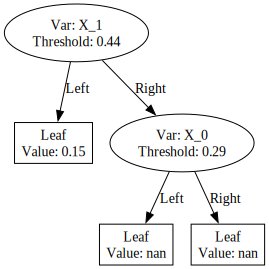

In [21]:
tree_com = move.proposed.trees[0]
filename3 = "tree_com"
visualize_tree(tree_com, filename=filename3, format="png")

In [22]:
tearDown(filename1)
tearDown(filename2)
tearDown(filename3)
tearDown(filename_g)
tearDown(filename_gg)
tearDown(filename_g2)

# Birth & Death

In [23]:
trees = [tree_gg,tree_g]
params = Parameters(trees, {"eps_sigma2": 1})
params.trees

[Tree(vars=[ 1 -1  1 -2 -2 -1 -1 -2], thresholds=[0.43751698        nan 0.52339864        nan        nan        nan
         nan        nan], leaf_vals=[       nan 0.14604766        nan        nan        nan 0.43124902
  0.45360376        nan], n_vals=[120  51  69  -2  -2  12  57  -2]),
 Tree(vars=[ 1 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.43751698        nan        nan        nan        nan        nan
         nan        nan], leaf_vals=[       nan 0.14503477 0.45004702        nan        nan        nan
         nan        nan], n_vals=[120  51  69  -2  -2  -2  -2  -2])]

In [24]:
move = Birth(params, trees_changed=[0])
move.propose(rng)
move.proposed.trees

[Tree(vars=[ 1 -1  1 -2 -2 -1 -1 -2], thresholds=[0.43751698        nan 0.52339864        nan        nan        nan
         nan        nan], leaf_vals=[       nan 0.14604766        nan        nan        nan 0.43124902
  0.45360376        nan], n_vals=[120  51  69  -2  -2  12  57  -2]),
 Tree(vars=[ 1 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.43751698        nan        nan        nan        nan        nan
         nan        nan], leaf_vals=[       nan 0.14503477 0.45004702        nan        nan        nan
         nan        nan], n_vals=[120  51  69  -2  -2  -2  -2  -2]),
 Tree(vars=[-1 -2], thresholds=[nan nan], leaf_vals=[nan nan], n_vals=[120  -2])]

In [25]:
params = move.proposed
move = Death(params, trees_changed=[1, 2])
move.propose(rng)
move.proposed.trees

[Tree(vars=[ 1 -1  1 -2 -2 -1 -1 -2], thresholds=[0.43751698        nan 0.52339864        nan        nan        nan
         nan        nan], leaf_vals=[       nan 0.14604766        nan        nan        nan 0.43124902
  0.45360376        nan], n_vals=[120  51  69  -2  -2  12  57  -2]),
 Tree(vars=[ 1 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.43751698        nan        nan        nan        nan        nan
         nan        nan], leaf_vals=[       nan 0.14503477 0.45004702        nan        nan        nan
         nan        nan], n_vals=[120  51  69  -2  -2  -2  -2  -2])]